In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [5]:
x_train_nhts = np.load("data/x_train_nhts.npy")
x_test_nhts = np.load("data/x_test_nhts.npy")
 
x_train_images = np.load("data/x_train_images.npy")
x_test_images = np.load("data/x_test_images.npy")
  

y_train = np.load("data/y_train.npy")
y_test = np.load("data/y_test.npy")
print("The sample size of training set is: ", x_train_nhts.shape[0])
print("The sample size of testing set is: ", x_test_nhts.shape[0])

The sample size of training set is:  3556
The sample size of testing set is:  889


In [6]:
# bridge numpy to torch
x_train_nhts_torch = torch.as_tensor(x_train_nhts).float() # specify floats for the inputs
x_train_images_torch = torch.as_tensor(x_train_images).float()
x_test_nhts_torch = torch.as_tensor(x_test_nhts).float()
x_test_images_torch = torch.as_tensor(x_test_images).float()
y_train_torch = torch.as_tensor(y_train[:,0])
y_test_torch = torch.as_tensor(y_test[:,0])
n_train = x_train_nhts.shape[0]
n_test = x_test_nhts.shape[0]
# inputs: x_train_nhts, x_train_images, x_test_nhts, x_test_images, y_train, and y_test; 
K = len(np.unique(y_train))
x_dim = x_train_nhts.shape[1]
# 
pd.value_counts(y_train[:,0])/y_train.shape[0]

2    0.339426
1    0.324241
3    0.250562
0    0.085771
dtype: float64

In [7]:
##### Type 2: CNN with images.
# To-Do: Use GPU...
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # To-Do: need to have more channels for higher accuracy. 
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=5, kernel_size=4, padding=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=4)
        # Question: Why is this 48*48 correct? bc 97//2 = 48
        self.fc1 = nn.Linear(in_features=10 * 48 * 48, out_features=80)
        self.fc2 = nn.Linear(in_features=80, out_features=K)
        self.relu = F.relu
        self.pool = F.max_pool2d
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        print(x.shape)
        out = self.relu(self.conv1(x))
        print(out.shape)
        out = self.pool(out, 2)
        print(out.shape)
        out = self.relu(self.conv2(out))
        print(out.shape)
        out = self.pool(out, 2)
        print(out.shape)
        out = out.reshape(out.size(0), -1)
        print(out.shape)
        out = self.relu(self.fc1(out))
        print(out.shape)
        out = self.fc2(out)
        print(out.shape)
        out = self.softmax(out)
        print(out.shape)
        return out

In [8]:
# normalize the data
x_train_images_norm_torch = x_train_images_torch/255.0
x_test_images_norm_torch = x_test_images_torch/255.0
# 
cnn_net = CNN().float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 150 # To-Do: need more epoches.
batch_size = 200 

In [9]:
# training
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for n_epoch in range(n_epoches):
    # create permutation for batch training
    # To-Do: add permutation for SGD...But it is slow.
#    permutation = torch.randperm(x_train_images_norm_torch.size()[0])
    for i in range(0, x_train_images_norm_torch.size()[0], batch_size):
        print(n_epoch, i)
        # clear gradients first (for each iteration!)!
        optim.zero_grad()
        # forward pass
        batch_x, batch_y = x_train_images_norm_torch[i:i+batch_size, :, :, :].to(device), y_train_torch[i:i+batch_size].to(device)
        batch_y_pred_train = cnn_net(batch_x)
        # loss 
        loss = criterion(batch_y_pred_train.squeeze(), batch_y)
        # compute gradients
        loss.backward()
        # one step optim
        optim.step()

    # eval training accuracy
    with torch.no_grad():
        y_pred_train = cnn_net(x_train_images_norm_torch.to(device))
        loss_train = criterion(y_pred_train.squeeze(), y_train_torch.to(device))
        train_losses.append(loss_train)
        
        _, predict_train = torch.max(y_pred_train, axis = 1)
        accuracy_train = (predict_train == y_train_torch.to(device)).sum().item()/n_train  
        train_accuracies.append(accuracy_train)
        # evaluate testing sets step-wise
        cnn_net.eval()
        y_pred_test = cnn_net(x_test_images_norm_torch.to(device))
        loss_test = criterion(y_pred_test.squeeze().to(device), y_test_torch.to(device))
        test_losses.append(loss_test)
        _, predict_test = torch.max(y_pred_test.to(device), axis = 1)
        accuracy_test = (predict_test == y_test_torch.to(device)).sum().item()/n_test
        test_accuracies.append(accuracy_test)
        # print info
        if n_epoch % 1 == 0:
            print('Epoch {}: train loss: {}; test loss: {}'.format(n_epoch, loss.item(), loss_test.item()))
            print('Epoch {}: train accuracy: {}; test accuracy: {}'.format(n_epoch, accuracy_train, accuracy_test))


# notes:
# CPU training: about 30 mins, with SIMPLEST CNN architecture, 20 epoches and 200 batch_size. 
# training accuracy: 60%; testing accuracy: 60%.     

0 0
torch.Size([200, 4, 200, 200])
torch.Size([200, 5, 201, 201])
torch.Size([200, 5, 100, 100])
torch.Size([200, 10, 97, 97])
torch.Size([200, 10, 48, 48])
torch.Size([200, 23040])
torch.Size([200, 80])
torch.Size([200, 4])
torch.Size([200, 4])
0 200
torch.Size([200, 4, 200, 200])
torch.Size([200, 5, 201, 201])
torch.Size([200, 5, 100, 100])
torch.Size([200, 10, 97, 97])
torch.Size([200, 10, 48, 48])
torch.Size([200, 23040])
torch.Size([200, 80])
torch.Size([200, 4])
torch.Size([200, 4])
0 400
torch.Size([200, 4, 200, 200])
torch.Size([200, 5, 201, 201])
torch.Size([200, 5, 100, 100])
torch.Size([200, 10, 97, 97])
torch.Size([200, 10, 48, 48])
torch.Size([200, 23040])
torch.Size([200, 80])
torch.Size([200, 4])
torch.Size([200, 4])
0 600
torch.Size([200, 4, 200, 200])
torch.Size([200, 5, 201, 201])
torch.Size([200, 5, 100, 100])
torch.Size([200, 10, 97, 97])
torch.Size([200, 10, 48, 48])
torch.Size([200, 23040])
torch.Size([200, 80])
torch.Size([200, 4])
torch.Size([200, 4])
0 800
torc

RuntimeError: CUDA out of memory. Tried to allocate 2.68 GiB (GPU 0; 15.75 GiB total capacity; 2.24 GiB already allocated; 215.88 MiB free; 72.21 MiB cached)

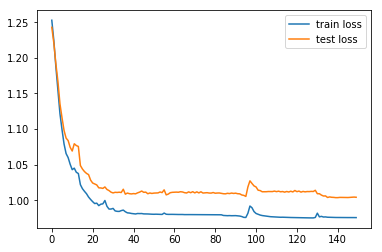

In [8]:
plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "test loss")
plt.legend()

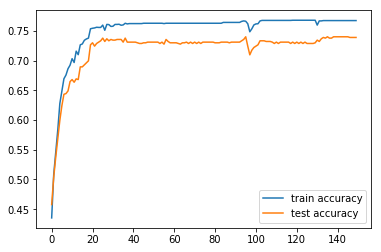

In [9]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(test_accuracies, label = "test accuracy")
plt.legend()

In [10]:
torch.save(cnn_net.state_dict(), "data/cnn_net_ADAM_2conv")